In [1]:
import boto3
import sagemaker

In [2]:
print(boto3.__version__)
print(sagemaker.__version__)

1.17.39
2.32.0


In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
print(bucket)
print(role)

sagemaker-us-east-2-805291263703
arn:aws:iam::805291263703:role/service-role/AmazonSageMaker-ExecutionRole-20200826T145400


In [4]:
prefix = 'pytorch-text-recognize'

In [47]:
model_path = sess.upload_data('model.tar.gz', bucket=bucket, key_prefix=prefix)
print(model_path)

s3://sagemaker-us-east-2-805291263703/pytorch-text-recognize/model.tar.gz


# Create model, endpoint configuration, endpoint

In [7]:
import time

In [9]:
sm = boto3.client('sagemaker')

In [62]:
model_name = prefix + '-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)

pytorch-text-recognize-2021-03-31-08-00-55


In [63]:
response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [
        {
            'Image': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.6-cpu-py3',
            'Mode': 'SingleModel',
            'ModelDataUrl': 's3://{}/{}/model.tar.gz'.format(bucket, prefix),
            'Environment': {
                'SAGEMAKER_PROGRAM': 'inference.py',
                'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code',
                'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
                'SAGEMAKER_REGION': 'us-east-2',
                'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'
            }
        }
    ]
)
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-2:805291263703:model/pytorch-text-recognize-2021-03-31-08-00-55', 'ResponseMetadata': {'RequestId': 'ee09b796-458d-4df2-a449-448920b7dbb9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ee09b796-458d-4df2-a449-448920b7dbb9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '104', 'date': 'Wed, 31 Mar 2021 08:00:56 GMT'}, 'RetryAttempts': 0}}


In [64]:
epc_name = prefix + '-epc-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(epc_name)

pytorch-text-recognize-epc-2021-03-31-08-00-59


In [65]:
response = sm.create_endpoint_config(
    EndpointConfigName = epc_name,
    ProductionVariants = [
        {
            'ModelName': model_name,
            'VariantName': 'variant-1',
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m5.large',
            'InitialVariantWeight': 1
        }
    ]
)
print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint-config/pytorch-text-recognize-epc-2021-03-31-08-00-59', 'ResponseMetadata': {'RequestId': 'b158c8b6-98de-4626-8272-e2d641b6f763', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b158c8b6-98de-4626-8272-e2d641b6f763', 'content-type': 'application/x-amz-json-1.1', 'content-length': '127', 'date': 'Wed, 31 Mar 2021 08:01:00 GMT'}, 'RetryAttempts': 0}}


In [66]:
ep_name = prefix + '-ep-' + time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
print(ep_name)

pytorch-text-recognize-ep-2021-03-31-08-01-02


In [67]:
response = sm.create_endpoint(
    EndpointName = ep_name,
    EndpointConfigName = epc_name
)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-text-recognize-ep-2021-03-31-08-01-02', 'ResponseMetadata': {'RequestId': '4aef11f0-cc38-4788-a3a1-db057f882164', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4aef11f0-cc38-4788-a3a1-db057f882164', 'content-type': 'application/x-amz-json-1.1', 'content-length': '113', 'date': 'Wed, 31 Mar 2021 08:01:03 GMT'}, 'RetryAttempts': 0}}


In [68]:
sm.describe_endpoint(EndpointName=ep_name)

{'EndpointName': 'pytorch-text-recognize-ep-2021-03-31-08-01-02',
 'EndpointArn': 'arn:aws:sagemaker:us-east-2:805291263703:endpoint/pytorch-text-recognize-ep-2021-03-31-08-01-02',
 'EndpointConfigName': 'pytorch-text-recognize-epc-2021-03-31-08-00-59',
 'EndpointStatus': 'Creating',
 'CreationTime': datetime.datetime(2021, 3, 31, 8, 1, 3, 571000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 3, 31, 8, 1, 3, 571000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '68f77b56-6cb1-447d-995f-fdbf96f97c15',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '68f77b56-6cb1-447d-995f-fdbf96f97c15',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '342',
   'date': 'Wed, 31 Mar 2021 08:01:05 GMT'},
  'RetryAttempts': 0}}

In [69]:
waiter = sm.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=ep_name)

# Inference

In [20]:
import cv2
import os
import numpy as np
from io import BytesIO
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
smrt = boto3.client('sagemaker-runtime')

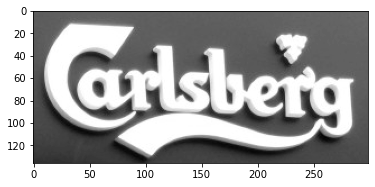

In [128]:
# im = cv2.imread('./word/6/572.jpg')
im = cv2.imread('./134_2.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')
plt.show()

In [129]:
buffer = BytesIO()
np.save(buffer, im)

In [130]:
response = smrt.invoke_endpoint(
        EndpointName=ep_name,
        Body=buffer.getvalue(),
        ContentType='application/x-npy'
    )
response['Body'].read()

b'["g-------r-i-s-b--e--r-g---", "grisberg"]'

# Delete endpoint, endpoint configuration and model

In [131]:
sm.delete_endpoint(EndpointName=ep_name)

{'ResponseMetadata': {'RequestId': 'd1d2d74d-cbf0-4f79-9529-064b0544cccb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd1d2d74d-cbf0-4f79-9529-064b0544cccb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 31 Mar 2021 08:42:34 GMT'},
  'RetryAttempts': 0}}

In [132]:
sm.delete_endpoint_config(EndpointConfigName=epc_name)

{'ResponseMetadata': {'RequestId': '0c99d2c9-3b21-4ec5-b500-2d968f6b191d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0c99d2c9-3b21-4ec5-b500-2d968f6b191d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 31 Mar 2021 08:42:36 GMT'},
  'RetryAttempts': 0}}

In [133]:
sm.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': '34c737fd-76a7-419e-aa35-40a854008185',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '34c737fd-76a7-419e-aa35-40a854008185',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 31 Mar 2021 08:42:38 GMT'},
  'RetryAttempts': 0}}